In [1]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv
import time
import seaborn as sns
sns.set_style("white")

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from flopy.utils.sfroutputfile import SfrFile

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

import spotpy
from spotpy.objectivefunctions import rmse
from spotpy.objectivefunctions import kge
from spotpy.objectivefunctions import correlationcoefficient as r
from spotpy.objectivefunctions import bias
from spotpy.objectivefunctions import nashsutcliffe as nse

def metrics(x,y): #x = obs, y = sim
    return [bias(x,y),rmse(x,y),r(x,y),nse(x,y),kge(x,y)]


def NSE(predictions,targets):
    mse = np.mean((predictions - targets) ** 2)
    nse = 1 - (mse / np.var(targets))
    return nse

modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput"

C:\Users\davem\anaconda3\lib\site-packages\spotpy\algorithms\padds.py:5: DeprecationWarning: Please use `ConvexHull` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, QhullError
C:\Users\davem\anaconda3\lib\site-packages\spotpy\algorithms\padds.py:5: DeprecationWarning: Please use `QhullError` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, QhullError


(692,)


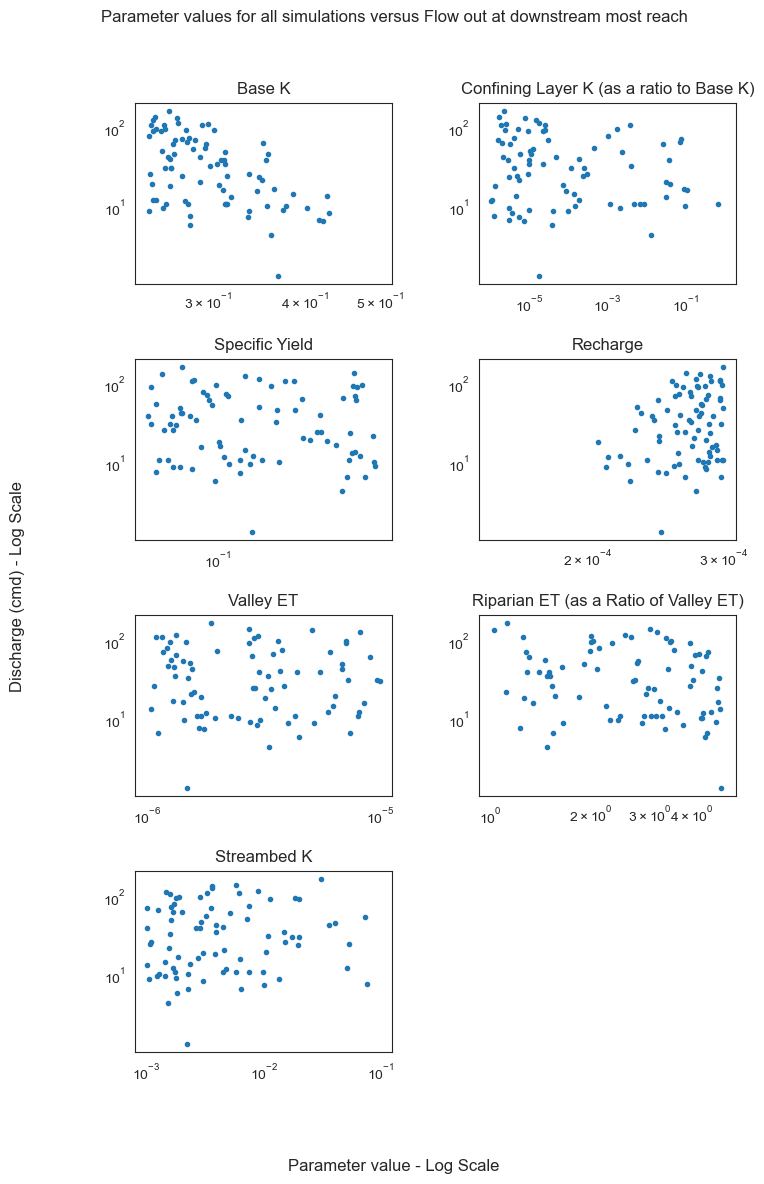

In [2]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio', 'Qout']
col_dict = {'K':'Base K', 'Low_K_ratio': 'Confining Layer K (as a ratio to Base K)', 'Sy':'Specific Yield', 'Rech':'Recharge', 'ET_valley':'Valley ET', 'ET_rip_ratio':'Riparian ET (as a Ratio of Valley ET)', 'Stream_K_ratio':'Streambed K'}

# load dataset
data = np.loadtxt("ModflowSfrWellOutput750Test3.txt")
#data = np.loadtxt("ModflowSfrOutput2500New.txt")

df = pd.DataFrame(data, columns = col_names)

print(df.index.shape) #how big is it 

#Set inputs and targets

X = df[col_names[:-1]] 
Y = df[col_names[-1]] #the last column in the saved csv is the flow at reach 49 - this is for ease of testing - other reaches are brought in later 


fig, axs = plt.subplots(4, 2, sharex=False, sharey=False,figsize=(8, 12))
fig.suptitle('Parameter values for all simulations versus Flow out at downstream most reach')
fig.supylabel('Discharge (cmd) - Log Scale')
fig.supxlabel('Parameter value - Log Scale')
fig.tight_layout(pad = 3.5)
fig.delaxes(axs[3,1])
# for i in range(len(col_names) - 1):
#     axs.plot(X[col_names[i]],Y,'k.')
i=0
for row in axs:
    for col in row: 
        col.plot(X[col_names[i]],Y,'.')
        col.title.set_text(col_dict[col_names[i]])
        col.set_xscale('log')
        col.set_yscale('log')
        if i < (len(col_names)-2):
            i+=1
        else:
            break

#plot out the parameters versus stream leakage
# for i in range(len(col_names) - 1):
#     plt.plot(X[col_names[i]],Y,'k.')
#     plt.ylabel('Reach Outflow Discharge (cfs)')
#     plt.title(col_dict[col_names[i]])
#     plt.yscale('log')
#     plt.xscale('log')
#     plt.show()
    
    

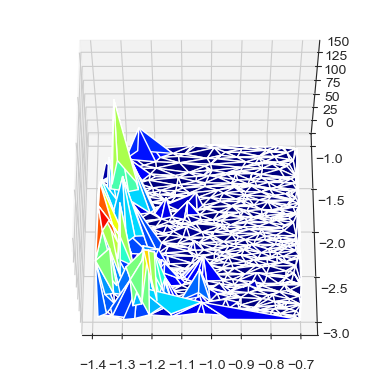

In [102]:
# data = np.loadtxt("ModflowParams7-750Test3.txt")
# #data = np.loadtxt("ModflowSfrOutput2500New.txt")
# df = pd.DataFrame(data)
# #Set inputs and targets

# K2 = df[6]
# data = np.loadtxt("ModflowParams7-750Test.txt")
# #data = np.loadtxt("ModflowSfrOutput2500New.txt")
# df = pd.DataFrame(data)
# #Set inputs and targets

# K = df[6]

# plt.plot(K2, '.', label = 'new')
# plt.plot(K,'.', label = 'Original')
# #plt.yscale('log')
# plt.legend()


# print(K.max(),K2.max())

from mpl_toolkits.mplot3d import Axes3D

x1 = np.linspace(X[col_names[0]].min(), X[col_names[0]].max(), len(X[col_names[0]].unique()))
y1 = np.linspace(X[col_names[6]].min(), X[col_names[6]].max(), len(X[col_names[6]].unique()))
x2, y2 = np.meshgrid(x1, y1)
z2 = griddata((X[col_names[0]], X[col_names[6]]), Y, (x2, y2), method='cubic')

ax = plt.figure().add_subplot(projection='3d')
#ax = fig.gca(projection='3d')
#ax.plot_trisurf(X[col_names[0]], X[col_names[6]], Y,cmap=cm.coolwarm)
# ax.set_zlim(-1.01, 1.01)
ax.plot_trisurf(np.log(X[col_names[0]]), np.log10(X[col_names[6]]), Y, cmap = cm.jet)

ax.view_init(60, -90,0)

# x, x2 = np.meshgrid(X[col_names[0]], X[col_names[6]])
# fig = plt.figure()
# ax = Axes3D(fig)
# surf = ax.plot_trisurf(x,x2 , Y, cmap=cm.jet)
# fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.savefig('teste.pdf')
plt.show()

In [103]:
#Get output at every reach

#load list of runs that did not converge so we can take those runs out
error_list = np.loadtxt("ErrorSS_SfrWell750Test3.txt")
eidx = np.array(error_list)[:,0].astype(int)
# #print(eidx)
temprange = np.arange(750)
#temprange = np.arange(100)

error_free = np.delete(temprange, eidx, axis=0)

if eidx.shape[0] == 0:
    error_free = temprange #if no errors

#Sey up arrays to store reach data and budget data
ReachQ = np.ndarray((len(error_free),50))
ReachQAqf = np.ndarray((len(error_free),50))
stage = np.ndarray((len(error_free),50))
depth = np.ndarray((len(error_free),50))
cond = np.ndarray((len(error_free),50))

budge_array = np.ndarray((len(error_free),1))

plt.figure(figsize=(6,5))

for j,i in enumerate(error_free):
    modelname = "ScenarioSfrWell750Test3_"+str(i)
    sfrout = SfrFile(modws+'\\'+modelname+'.sfr.out')
    Sfrdf = sfrout.get_dataframe() 
    ReachQ[j] = Sfrdf.Qout
    plt.plot(Sfrdf.Qout)
    ReachQAqf[j] = Sfrdf.Qaquifer
    stage[j] = Sfrdf.stage
    depth[j] = Sfrdf.depth
    cond[j] = Sfrdf.Cond
    #budget files
    #mf_list = flopy.utils.mflistfile.MfListBudget(modws+'/'+modelname+'.list')
    #budgedf, cumdf = mf_list.get_dataframes()
    #budge_array[j] = budgedf.RECHARGE_IN / budgedf.ET_OUT
print(Sfrdf.columns)  
#plt.yscale('log')
plt.ylim((0.01,np.max(ReachQ)+10))
plt.ylabel('Flow out of Reach (cmd)')
plt.xlabel('Reach Number')
plt.title('Streamflow change across reaches for all simulations')
plt.show()

#interpolate Nan values
nans, x= np.isnan(ReachQ), lambda z: z.nonzero()[0]
ReachQ[nans]= np.interp(x(nans), x(~nans), ReachQ[~nans])
#print("Nans: " + str(len(nans)))

#Get rid of negative infinities
ninf = float('-inf')
ReachQ[ReachQ == ninf] = 0
ReachQ[ReachQ < 1e-300] = 0

plt.figure(figsize=(6,5))
for i in range(len(error_free)):
    plt.plot(ReachQAqf[i])
plt.xlabel("Reach Number")
plt.ylabel("Aquifer Discharge (cmd)")
plt.title("Steady State Scenario - Aquifer Discharge along each Reach")
plt.show()

ReachQdf = pd.DataFrame(ReachQ)

numgrz = [len(ReachQdf[i][ReachQdf[i] > 0].index)/len(ReachQdf.index) for i in range(50)] 

plt.plot(numgrz[1:48])

plt.xlabel("Reach Number")
plt.ylabel("Fraction of Simulations with Q > 0")
plt.title("Fraction of Wet simulations for each Reach")
plt.show()
#print('Number of simulations > 0 : ' + str(numgrz))

FileNotFoundError: [Errno 2] No such file or directory: 'D:/mfoutput\\ScenarioSfrWell750Test3_0.sfr.out'

<Figure size 600x500 with 0 Axes>

In [ ]:
print(stage[:][25].mean(),stage[:][25].max(),stage[:][25].min())
print(depth[:][25].mean(),depth[:][25].max(),depth[:][25].min())
plt.figure(figsize=(8,5))
for i in range(len(error_free)):
    plt.plot(stage[i])
plt.show()

plt.figure(figsize=(8,5))
for i in range(len(error_free)):
    plt.plot(depth[i])
plt.show()
for i in range(len(error_free)):
    plt.plot(cond[i])
plt.show()

In [ ]:
#print(ReachQdf[32][ReachQdf[32] < 75])
#print(X.loc[[3,10,13,69,127,157,177,178]])
fig, axs = plt.subplots(4, 2, sharex=False, sharey=False,figsize=(8, 10))
fig.suptitle('Parameter Values for all Simulations with Reach 25 Outflow (cmd)')
fig.supylabel('Discharge (cmd) - Log Scale')
fig.supxlabel('Parameter values')
fig.tight_layout(pad = 3.5)
fig.delaxes(axs[3,1])
# for i in range(len(col_names) - 1):
#     axs.plot(X[col_names[i]],Y,'k.')
i=0
logpars = [1,2,4,6]
for row in axs:
    for col in row: 
        col.plot(X[col_names[i]],ReachQdf[25],'.')
        col.title.set_text(col_dict[col_names[i]])
        if i in logpars:
            col.set_xscale('log')
        col.set_yscale('log')
        if i < (len(col_names)-2):
            i+=1
        else:
            break

In [ ]:
#examine flows for every reach compared to ds most reach (49)
#print(ReachQdf.head())
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Plotting sets of reaches to the final reach outflow')
fig.supylabel('Discharge')
fig.supxlabel('Discharge at Downstream Reach')

k=10
for row in axs:
    for col in row:        
        for i in range(k,k+10,10):
            col.plot(ReachQdf[49],ReachQdf[i], '.')
            col.title.set_text('Reaches ' +str(k) +' through ' +str(k+10))
        k+=10

plt.xlim(0,int(ReachQdf[49].max()))
plt.ylim(0,int(ReachQdf[49].max()))
plt.show()

    
ReachQdf.corrwith(ReachQdf[49]).plot()
plt.title('Correlation of All Reaches with Reach 49 Q out ')
plt.ylabel('Pearson\'s r')
plt.xlabel('Reach Number')

## Now for the Modflow Cell Heads

In [112]:
ibound = np.loadtxt('ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T
print(all_well_loc) #nrow,ncol

[[ 1  5]
 [ 1  6]
 [ 1  7]
 ...
 [48 16]
 [48 17]
 [48 18]]


In [114]:
#Get Head data for All active wells

#load in Ibound and find active cells in model - then put it into a list of well locations

# 
#error_free = b
#error_free = X2.index
#error_free = np.delete(temprange, eidx, axis=0)

well_head = np.empty((len(error_free),all_well_loc.shape[0]))
well_error_sim = []
#well_error_num = []
for j, i in enumerate(error_free):
#for j, i in enumerate(df_flow.index):
    modelname = "ScenarioSfrWell750Test3_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
    head = headobj.get_alldata(nodata=0)#-9.9998999e+02)
    for k in range(all_well_loc.shape[0]):        
        h = head[0][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])]        #ntime, nlay, nrow, ncol
        if h < -1e10: #really low values for dry cells are throwing off the std deviations so adjusted it to 0 
            h = 45 #bottom of first layer
        
        well_head[j][k] = h
        #if (well_head[k][j] < 0) or (well_head[k][j] > 200) or np.isnan(well_head[k][j]):
        if (well_head[j][k] > 200) or np.isnan(well_head[j][k]):
            well_error_sim.append(i)
## Delete out simulations where well head is twice the average

new_zone = X.loc[~X.index.isin(np.unique(well_error_sim))]
#new_zone.head
well_head_df = pd.DataFrame(well_head, index = X.index)
well_head_df = well_head_df.loc[new_zone.index]
# new_well_head = np.delete(well_head, well_error_num, 1)

print(len(well_head_df.index))
#print(len(np.unique(well_error_sim)))
# for i in range(well_head_df.shape[1]):     
#     dropindex = well_head_df[well_head_df[i] > 200].index
#     well_head_df = well_head_df.drop(dropindex)
#     #well_head_df = well_head_df.where(well_head_df[i] > 0, other= 0)# df[cols2].where(df[cols]<=0.9, other=0)
#     #dropindex = well_head_df[well_head_df[i] < -1e10].index
#     #well_head_df[dropindex] = 0

# print(len(well_head_df.index))

# Split dataset into training set and test set, default here is 30% test
test = X.loc[well_head_df.index]
test_q = Y.loc[well_head_df.index]

#well_head_df.to_pickle('WellHead_SS.pkl')


692


well num, well col, well row 

1017 25 12
25 12


C:\Users\davem\AppData\Local\Temp\ipykernel_10884\3984831359.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


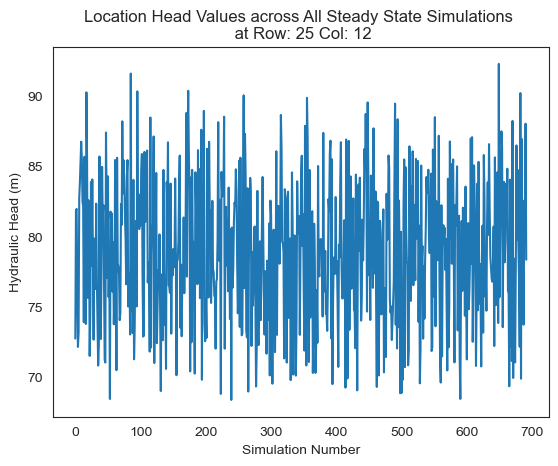

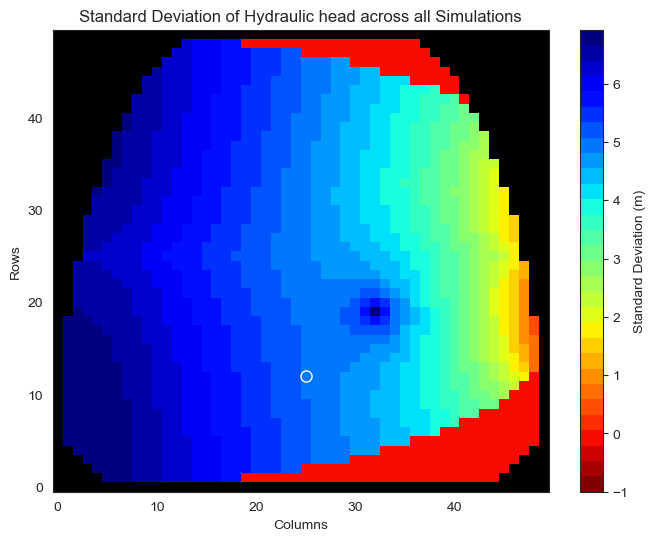

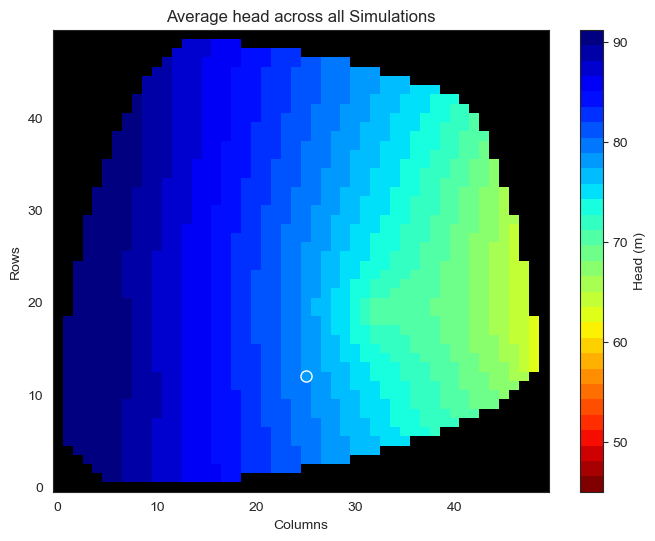

In [111]:
wn = 1017
print("well num, well col, well row \n")
print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]))
well_head_df[wn].plot()
plt.xlabel('Simulation Number')
plt.ylabel('Hydraulic Head (m)')
plt.title("Location Head Values across All Steady State Simulations \n at Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1]))


kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

# test_head = well_head_df.to_numpy().reshape((len(simindex),well_head.shape[0],numTS))
# #print(test_head)
# # well_head_var = test.var(axis=(0,1))
# # print(well_head_var.shape)
# # #print(well_head_var)
# well_head_var = np.empty((well_head.shape[0],numTS))

# for i in range(well_head.shape[0]):
#     for k in range(numTS):
#         well_head_var[i][k] = np.std(test_head[:,i,k])
        
# print(well_head_var)
wellmesh = np.ndarray((50,50))
wellmesh[:][:] = -1e30

wellmesh2 = wellmesh.copy()
#well_head_df[1060].plot()
print(int(all_well_loc[wn, 0]),int(all_well_loc[wn, 1]))
for i in range(all_well_loc.shape[0]):
    wellmesh[int(all_well_loc[i, 0]),int(all_well_loc[i, 1])] = np.std(well_head[:,i])
    wellmesh2[int(all_well_loc[i, 0]),int(all_well_loc[i, 1])] = well_head_df[i].mean()
#print(well_head_df[wn].std())
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("k")


plt.figure(figsize=(8,6))

plt.pcolormesh(KK,GG,wellmesh,cmap = cmap2, vmin = -1,shading='nearest')
plt.colorbar(label = 'Standard Deviation (m)')
plt.plot(int(all_well_loc[wn][0]), int(all_well_loc[wn][1]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Example Location")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Standard Deviation of Hydraulic head across all Simulations')
plt.show()

plt.figure(figsize=(8,6))

plt.pcolormesh(KK,GG,wellmesh2,cmap = cmap2, vmin = 45, shading='nearest')
plt.colorbar(label = 'Head (m)')
plt.plot(int(all_well_loc[wn][0]), int(all_well_loc[wn][1]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Example Location")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Average head across all Simulations')
plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')

#plt.imshow(wellmesh, cmap='RdBu')


## Using Heads to predict stream Flow

In [14]:
# Since we changed the number of wells - use this for flow only outputs
#well_df = pd.DataFrame(new_well_head.transpose(), index = new_zone.index)

#well_sample = well_head_df.sample(frac = 0.1, axis = 1)

#if not pulling new heads
well_head_df = pd.read_pickle('WellHead_SS.pkl')


river_well_loc = np.where(all_well_loc[:,0] == 25)
#river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

#print(river_well_loc)
#print(len(all_well_loc))
CHBound_loc = np.where(all_well_loc[:,1] > 47) #
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)
#print(len(river_well_loc[0]))
well_head_noRiv = well_head_df.drop(drop_locs[0], axis = 1)
#well_head_noRiv = well_head_noRiv.drop(CHBound_loc[0], axis = 1)
#print(well_head_noRiv.shape)
new_zone_q = ReachQdf.loc[well_head_noRiv.index]

well_head_noRiv.columns = well_head_noRiv.columns.astype(str)

well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])

norm_well_df = (well_head_noRiv - np.min(well_head_noRiv.min().values))
norm_well_df = norm_well_df/ np.max(well_head_noRiv.max().values)
norm_well_df.columns = norm_well_df.columns.astype(str)

Fraction of wet simulations: 0.3627167630057804
{'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 2, 5, 10], 'max_leaf_nodes': [18, 53, 88, 123, 158, 193, 228, 263, 298, 333, None], 'min_impurity_decrease': [5, 15, 25, 35, 45], 'splitter': ['best']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'friedman_mse'}
RMSE:  14.774901733755533
NSE:  0.919148930837613
KGE:  0.8713408526426365


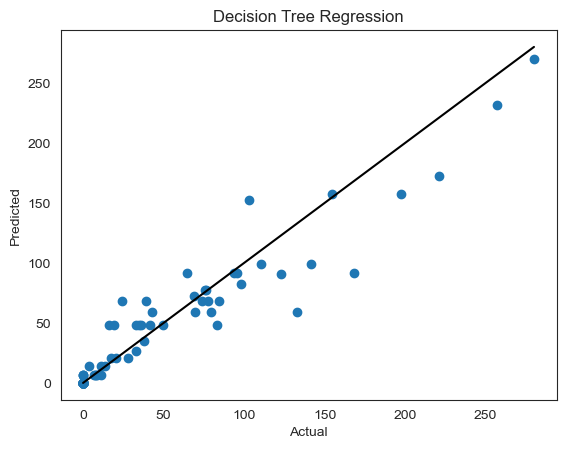

In [10]:
#choosing one well and finding the hyperparameters that best work for it 
rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)

rn = 25
print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn] > 0].index) / len(new_zone_q.index)))

X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2)

#split quality function
split_criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
#Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 or greater is recommened, 8 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
#maximum 
max_leaf_nodes = [int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

splitter = ['best']
# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease,
                'splitter': splitter}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
dtr = DecisionTreeRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dtr_random = RandomizedSearchCV(estimator = dtr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dtr_random.fit(X_train, y_train)
best_pars_dt = dtr_random.best_params_
print(best_pars_dt)

from sklearn.tree import plot_tree


best_random = dtr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
print("KGE: ", kge(y_test, y_pred))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_test)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

# _, ax = plt.subplots(figsize=(25, 25))
# _ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

## Tree using Wells to predict Qout

In [8]:
best_pars_dt = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'friedman_mse'}

Average NSE:  0.7903835335835725
Average KGE:  0.7715162662532057
Average Tree Depth:  2.0
Total time: 0.8480269908905029


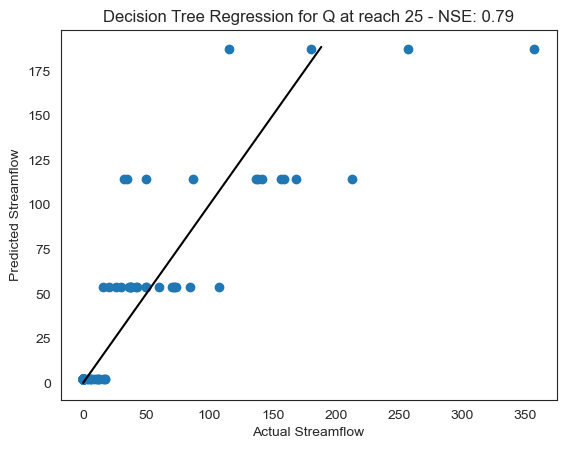

In [89]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

PredList = []
NSEList = []
KGEList = []
importanceList = []
depthlist = []



new_zone_q = np.log(ReachQdf.loc[well_head_noRiv.index]+1)
new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn = 25

imp_df = pd.DataFrame(index = well_head_noRiv.columns.astype('int'))


for i in range(n):
    well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
    #X_train, X_test, y_train, y_test = train_test_split(norm_well_df, new_zone_q[rn], test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23

    # Create Decisiton Tree Object
    Tree = DecisionTreeRegressor(
        #**best_pars_dt)
        max_depth = 2)

    # Train Decision Tree Classifer
    Tree = Tree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = Tree.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))
    KGEList.append(kge(y_test, y_pred))
    depthlist.append(Tree.get_depth())
    #feature importance
    feat_df = pd.DataFrame(Tree.feature_importances_, index = Tree.feature_names_in_.astype('int')) 
    imp_df = imp_df.merge(feat_df.rename(columns={0:i}), left_index=True, right_index = True)
    
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.nanmean(NSEList))
print("Average KGE: ", np.nanmean(KGEList))

print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results




print('Total time: ' + str(time.time()-t0))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Decision Tree Regression for Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

[0.8690860685439131, 0.06625926374147866, 0.06465466771460819]


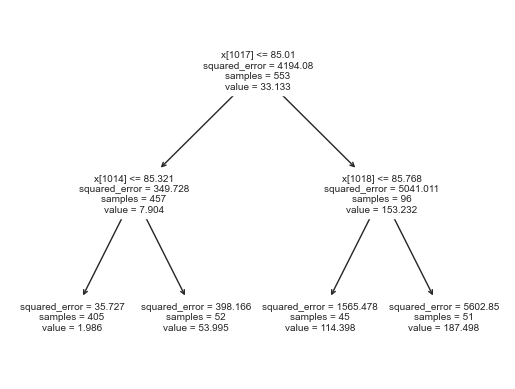

In [91]:
tree.plot_tree(Tree)
print(sorted(Tree.feature_importances_, reverse=True)[:3])

In [46]:
# print(well_head_df.mean())
# norm_well_df = (well_head_df - np.min(well_head_df.min().values))
# norm_well_df = norm_well_df/ np.max(norm_well_df.max().values)
# print(np.min(norm_well_df))
#plt.scatter(range(2012),norm_well_df.var().values)
# well = '1017'
# print(Tree.feature_importances_)
# plt.scatter(well_head_df[well],ReachQdf[well])

0.5118881619519204
0.7024040011689845
25      0.73299
pred    1.00000
dtype: float64


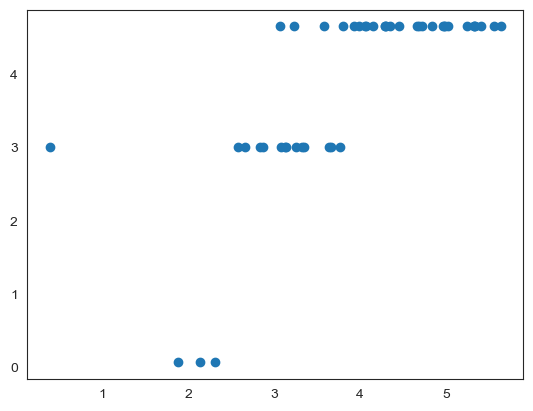

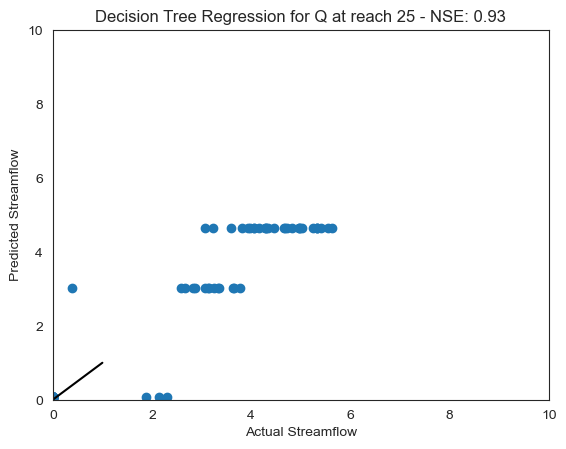

In [52]:
#imp_df.to_pickle('SteadyState_DT_Impdf.pkl')


test = pd.DataFrame(y_test)
test['pred'] = y_pred
test = test[test[25] > 0]
#print(test)
plt.scatter(test[25], test['pred'])

print(NSE(test[25], test['pred']))
print(kge(test[25], test['pred']))
print(test.corrwith(test['pred']))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred) +10
plt.plot([0, 1], [0, 1], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Decision Tree Regression for Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
plt.ylim((0,10))
plt.xlim((0,10))
# plt.yscale('log')
# plt.xscale('log')
#plt.legend()
plt.show()

Average NSE:  0.5846532152729662
Average Tree Depth:  3.6
Total time: 9.880637645721436


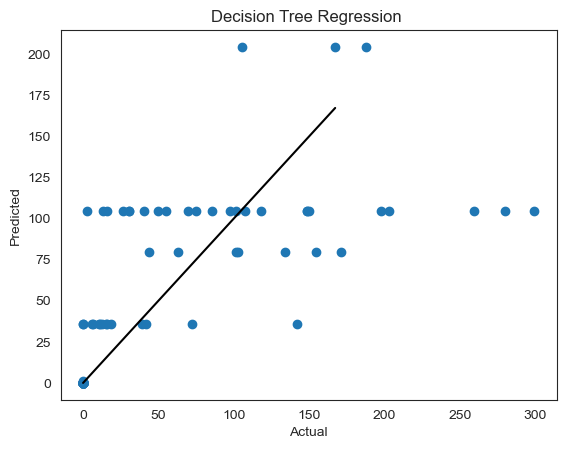

In [31]:
# RANDOM Tree 
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 100

PredList = []
NSEList = []
KGEList = []
importanceList = []
depthlist = []

new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn = 25

for i in range(n):
    well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
    # Create Random Forest Object
    Tree = ExtraTreeRegressor(**best_pars_dt, max_features = 1)
    )

    # Train Decision Tree Classifer
    Tree = Tree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = Tree.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test)) 
    KGEList.append(kge(y_pred, y_test))    
    depthlist.append(Tree.get_depth())
    #feature importance
    importanceList.append(Tree.feature_importances_)
    
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.nanmean(NSEList))
print("Average KGE: ", np.nanmean(KGEList))
print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results



t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(test_q)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Decision Tree Regression " #Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [41]:
print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

Fraction of wet simulations: 0.3627167630057804
0
0


[   0    1    2 ... 2009 2010 2011]
Number of Features used in Stress period 0: 1941
Sum of Importances in Stress period 0: 1.0


C:\Users\davem\AppData\Local\Temp\ipykernel_20032\996921326.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


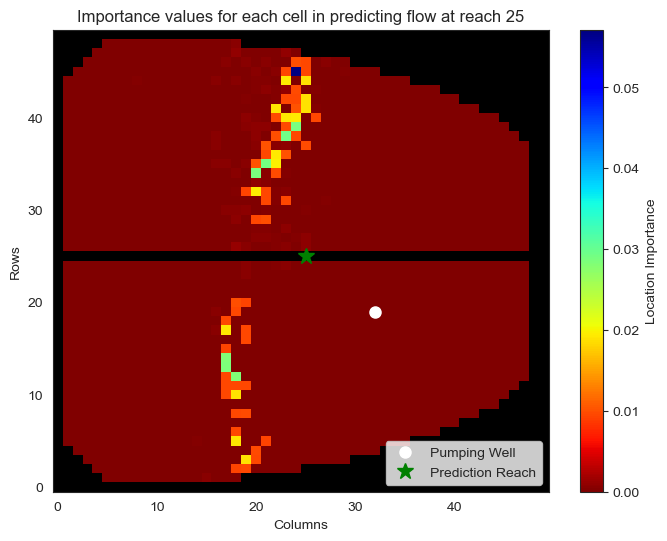

In [53]:
numTS = 1
n = 100
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid
dt_total_imp_df = imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
#Sum up all the stress periods for each well location
dt_AllTSimp = dt_total_imp_df.groupby(dt_total_imp_df.index // numTS).sum()

#get indicies of every feature per TS (stressperiod)
TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

for i in range(numTS):
    featInTS = np.intersect1d(dt_total_imp_df.index, TSIndices+i)
    print(featInTS)
    print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
    print("Sum of Importances in Stress period " + str(i) + ": " + str(dt_total_imp_df.loc[featInTS].sum()))
    
#Should probably use this now - it tracks the well location number with the index
#well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])


#feature importance Mapping
wellmesh_dt = np.ndarray((50,50))
wellmesh_dt[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

for k in dt_AllTSimp.index:
        wellmesh_dt[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = dt_AllTSimp.loc[k]



kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(dt_AllTSimp)
#vmax = 0.1
vmin = np.min(dt_AllTSimp)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_dt,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 19, marker="o", markersize=8, color="White", linestyle = "None", label="Pumping Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")

In [43]:
mostImportant = dt_total_imp_df.sort_values(ascending=False)[:5]
print(len(mostImportant.index))
print(mostImportant)

5
1074    0.032284
1365    0.030042
1076    0.023395
1266    0.022856
1316    0.022833
dtype: float64


Average NSE:  0.788361642040695


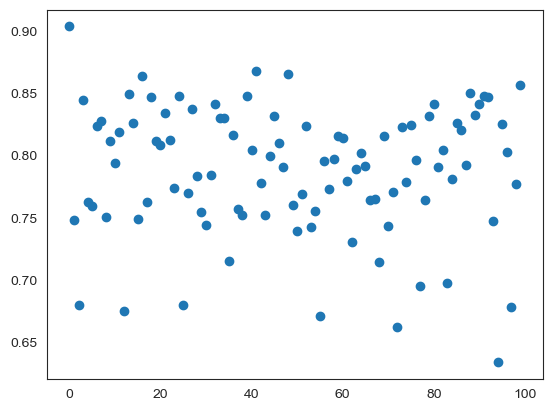

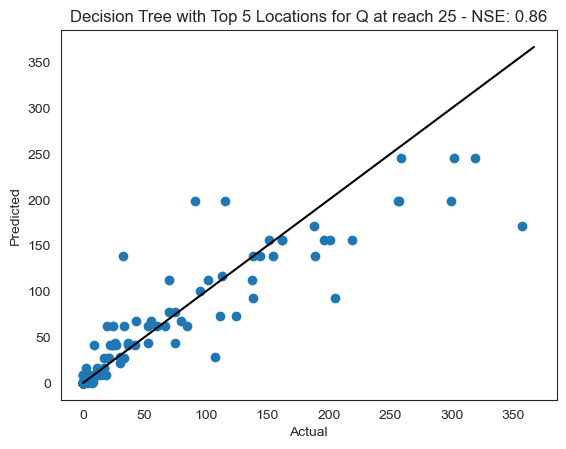

Total time: 2.042459487915039


In [21]:
# ONly using the most important cells for the decision tree 
t0 = time.time()
n = 100

PredList = []
NSEList = []
importanceList = []

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]
mostImpWellHead = well_head_df.loc[:,mostImportant.index]

for i in range(n):
    well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(mostImpWellHead, new_zone_q[rn], test_size=0.3) #random_state=1)
    # Create Random Forest Object
    Tree = DecisionTreeRegressor(**best_pars_dt
    #max_depth = 2 {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
    )

    # Train Decision Tree Classifer
    Tree = Tree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = Tree.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))
    #feature importance
    importanceList.append(Tree.feature_importances_)
   
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.mean(NSEList))
plt.scatter(range(n),NSEList)
#print(PredList[99])
plt.figure()
#for i in range(1):
plt.scatter(y_test, y_pred)
outmax = np.max(y_test) + 10
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Decision Tree with Top 5 Locations for Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

Fraction of wet simulations: 0.434971098265896


<Axes: >

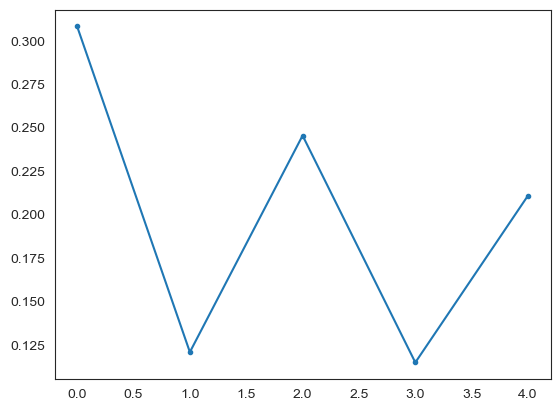

In [22]:
print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[10] > 0].index) / len(new_zone_q.index)))

WellStreamimportance = Tree.feature_importances_

miimportance_df = pd.DataFrame(importanceList).sum()/100

miimportance_df.plot(marker='.')

In [24]:
#feature importance Mapping
miwellmesh = np.ndarray((50,50))
miwellmesh[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, river_well_loc[0], axis = 0)
#for i in range(all_well_loc.shape[0]):
for i,k in enumerate(mostImportant.index):
    #if(all_well_loc[i,1] != 25):
    miwellmesh[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = miimportance_df[i] #np.sum(importanceList[:,i])  
print(miimportance_df)
print(mostImportant.index)

0    0.308184
1    0.120753
2    0.245395
3    0.114780
4    0.210889
dtype: float64
Int64Index([1076, 1366, 1126, 1127, 1124], dtype='int64')


C:\Users\davem\AppData\Local\Temp\ipykernel_10576\3800517588.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=10)


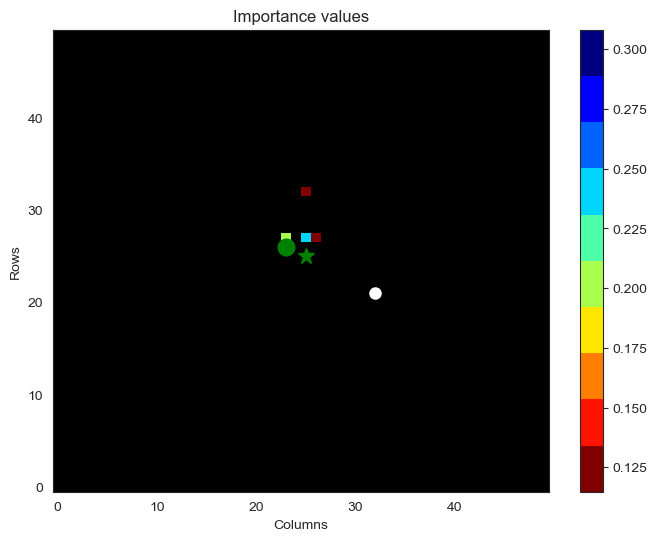

1076 23 26


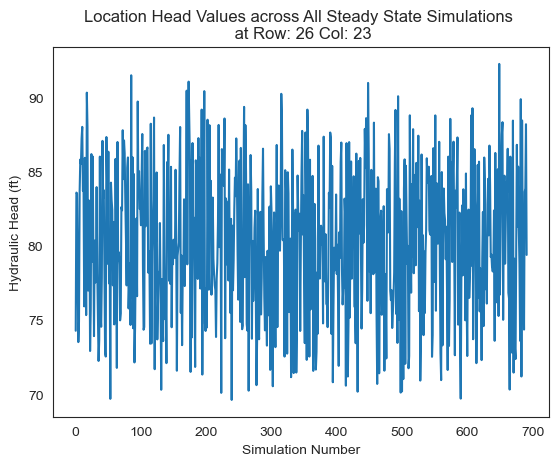

In [32]:
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid

cmap2 = cm.get_cmap("jet_r",lut=10)
cmap2.set_under("k")

vmax = np.max(miimportance_df)
#vmax = 1
vmin = np.min(miimportance_df)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,miwellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
plt.plot(int(well_loc_df.loc[wn, 1]),int(well_loc_df.loc[wn, 0]),marker="o", markersize=12, color="white", linestyle = "None",label="Most Important Loc")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar()
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Importance values')
plt.show()
wn = 1076
#int(well_loc_df.loc[wn, 1]), int(well_loc_df.loc[wn, 0])
print(wn,int(well_loc_df.loc[wn, 1]), int(well_loc_df.loc[wn, 0]))
well_head_df[wn].plot()
plt.xlabel('Simulation Number')
plt.ylabel('Hydraulic Head (ft)')
plt.title("Location Head Values across All Steady State Simulations \n at Row: " +str(well_loc_df.loc[wn, 0])+ " Col: " + str(well_loc_df.loc[wn, 1]))
plt.show()


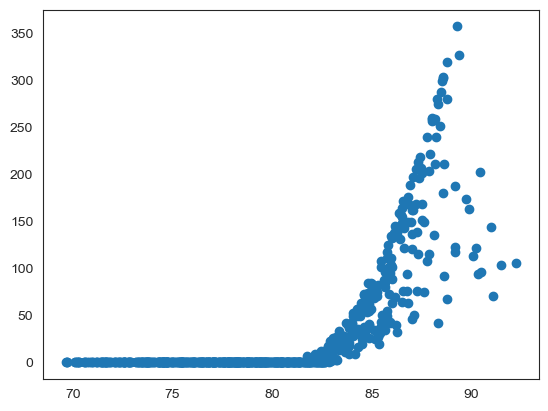

In [33]:

plt.scatter(well_head_df[wn],ReachQdf[rn])

In [34]:
# print(result.importances_mean)

# wellmesh = np.ndarray((50,50))
# wellmesh[:,:] = -1e30

# for i in range(all_well_loc.shape[0]):
#     wellmesh[int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = result.importances_mean[i] #np.sum(importanceList[:,i])

# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# cmap2 = cm.get_cmap("jet_r",lut=10)
# cmap2.set_under("k")

# vmax = np.max(0.001)
# vmin = np.min(WellStreamimportance)

# plt.figure(figsize=(8,6))
# plt.pcolormesh(KK,GG,wellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
# #plt.show()
# #plt.imshow(wellmesh, cmap='RdBu')
# plt.colorbar()
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Permutation Importance values')

## Gradient Boosting

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
{'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [25, 75, 125, 175, 225], 'criterion': ['squared_error', 'friedman_mse'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_leaf_nodes': [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 0.6, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease':

C:\Users\davem\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


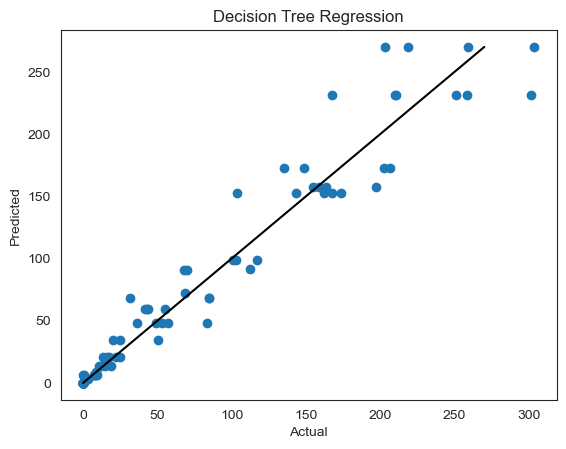

In [36]:
new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn =25
print(GradientBoostingRegressor().get_params().keys())
#choosing one well and finding the hyperparameters that best work for it 
rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2)
loss = ['squared_error', 'absolute_error', 'huber', 'quantile']
n_estimators = [int(x) for x in range(25,275,50)]
subsample = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
splitter = ['best']
#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#maximum 
max_leaf_nodes = [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None]#[int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'loss' : loss,
                'subsample':subsample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgr = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgr_random = RandomizedSearchCV(estimator = xgr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgr_random.fit(X_train, y_train)
best_pars_gr = xgr_random.best_params_
print(best_pars_gr)

#from sklearn.tree import plot_tree


best_random_gr = xgr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

In [44]:
best_pars_gr = {'subsample': 0.6, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 45, 'max_leaf_nodes': 52, 'max_features': 'sqrt', 'max_depth': 3, 'loss': 'squared_error', 'criterion': 'friedman_mse'}

Average NSE:  0.9510377441592571
Total time: 2.980376958847046


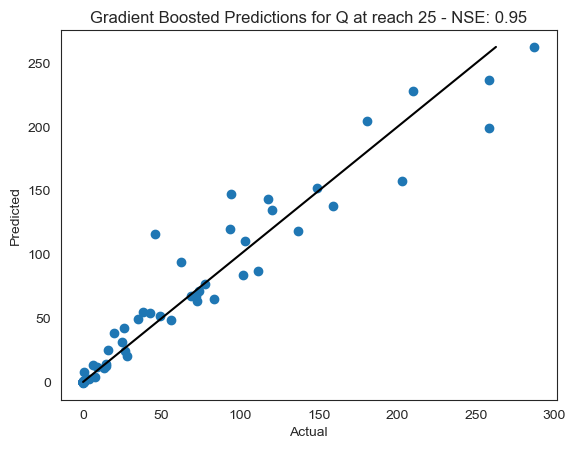

In [46]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

PredList = []
NSEList = []
importanceList = []
depthlist = []

gr_imp_df = pd.DataFrame(index = well_head_noRiv.columns.astype('int'))

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn = 25

for i in range(n):
    well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
    # Create Random Forest Object
    xgBest = GradientBoostingRegressor(**best_pars_gr)
   # Train Decision Tree Classifer
    xgBest.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = xgBest.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))
    #depthlist.append(xgBest.get_depth())
    #feature importance
    gr_feat_df = pd.DataFrame(xgBest.feature_importances_, index = xgBest.feature_names_in_.astype('int')) 
    gr_imp_df = gr_imp_df.merge(gr_feat_df.rename(columns={0:i}), left_index=True, right_index = True)
    
    
    
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.mean(NSEList))
#print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results



t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Gradient Boosting Predictions for Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [221]:
gr_imp_df.to_pickle('SteadyState_GB_Impdf.pkl')


1.0000000000000002


C:\Users\davem\AppData\Local\Temp\ipykernel_13108\1767113961.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


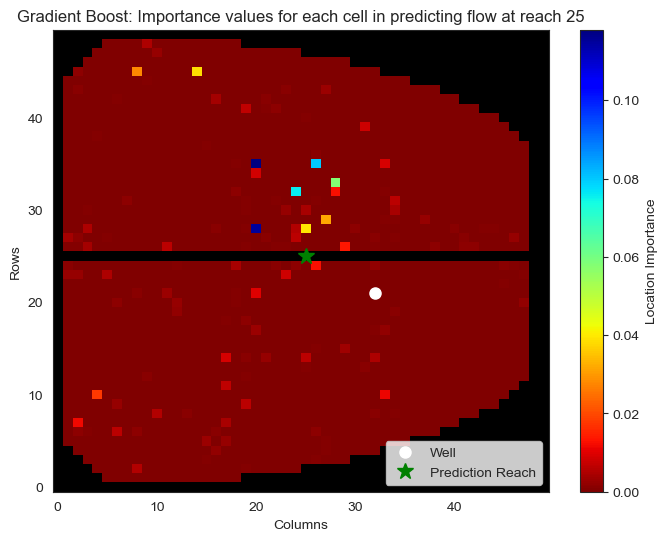

In [47]:
numTS = 1
gr_total_imp_df = gr_imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
print(gr_total_imp_df.sum())
#Sum up all the stress periods for each well location
gr_AllTSimp = gr_total_imp_df.groupby(gr_total_imp_df.index // numTS).sum()

#get indicies of every feature per TS (stressperiod)
TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

#Should probably use this now - it tracks the well location number with the index
#well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])


#feature importance Mapping
wellmesh_gr = np.ndarray((50,50))
wellmesh_gr[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

for k in gr_AllTSimp.index:
        wellmesh_gr[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = gr_AllTSimp.loc[k]
# for i in range(len(importance_df.index)):

#PLotting out the result grid

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(gr_AllTSimp)
#vmax = 0.1
vmin = np.min(gr_AllTSimp)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_gr,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Pumping Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Gradient Boosting: Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")

## Random Forest - Steady State

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [25, 75, 125, 175, 225], 'criterion': ['squared_error', 'friedman_mse'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10], 'max_leaf_nodes': [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
RMSE:  14.323115946437962


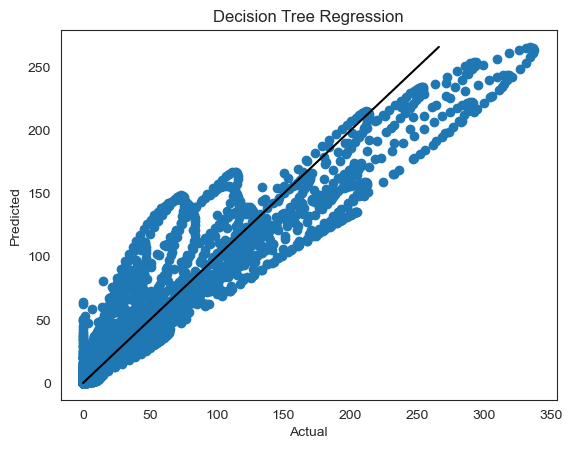

In [73]:
from sklearn.ensemble import RandomForestRegressor
rn = 25
# X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.3)#, random_state=1) #changed the random state to 1 - 2/27/23
#     # Create Random Forest Object

# #X_train, X_test, y_train, y_test = train_test_split(well_sample, test_q, test_size=0.3, random_state=0)

# RF = RandomForestRegressor(
# #max_depth = 2
# # n_estimators= 400,
# # min_samples_split = 2,
# # min_samples_leaf= 4,
# # max_features= 'sqrt',
# # max_depth= 10, 
# # bootstrap= True
    
# )#default Hyperparameters

# #print(RF.get_params())
new_zone_q = ReachQdf.loc[well_head_noRiv.index]

print(RandomForestRegressor().get_params().keys())
#choosing one well and finding the hyperparameters that best work for it 
rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2)
n_estimators = [int(x) for x in range(25,275,50)]
max_sample = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
#splitter = ['best']
bootstrap = ['True']
#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
#maximum 
max_leaf_nodes = [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None]#[int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
#max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                #'bootstrap' : bootstrap,
                'max_samples':max_sample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(estimator = rfr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rfr_random.fit(X_train, y_train)
best_pars_rf = rfr_random.best_params_
print(best_pars_rf)

#from sklearn.tree import plot_tree


best_random_rf = rfr_random.best_estimator_
y_pred = best_random_rf.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
#print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

In [218]:
best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}

Average NSE:  0.9672910532375043
Total time: 171.22435116767883


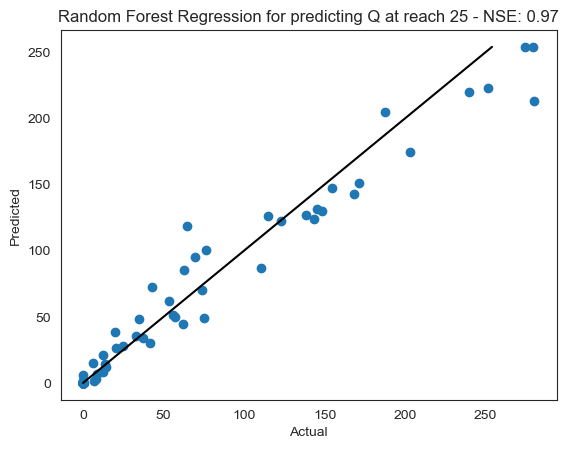

In [219]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

PredList = []
NSEList = []
importanceListRF = []
depthlist = []

rf_imp_df = pd.DataFrame(index = well_head_noRiv.columns.astype('int'))

rn = 25

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
 
    RF = RandomForestRegressor(**best_pars_rf)
    
    RF = RF.fit(X_train,y_train)
    y_pred = RF.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))

    rf_feat_df = pd.DataFrame(RF.feature_importances_, index = RF.feature_names_in_.astype('int')) 
    rf_imp_df = rf_imp_df.merge(rf_feat_df.rename(columns={0:i}), left_index=True, right_index = True)
       
  
    
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.nanmean(NSEList))
#print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results



t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Random Forest Regression for predicting Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [93]:
rf_imp_df.to_pickle('SteadyState_RF_Impdf.pkl')


NameError: name 'rf_imp_df' is not defined

1.0
[   0    1    2 ... 2009 2010 2011]
Number of Features used in Stress period 0: 1941
Sum of Importances in Stress period 0: 1.0
24 26


C:\Users\davem\AppData\Local\Temp\ipykernel_10884\3248992508.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


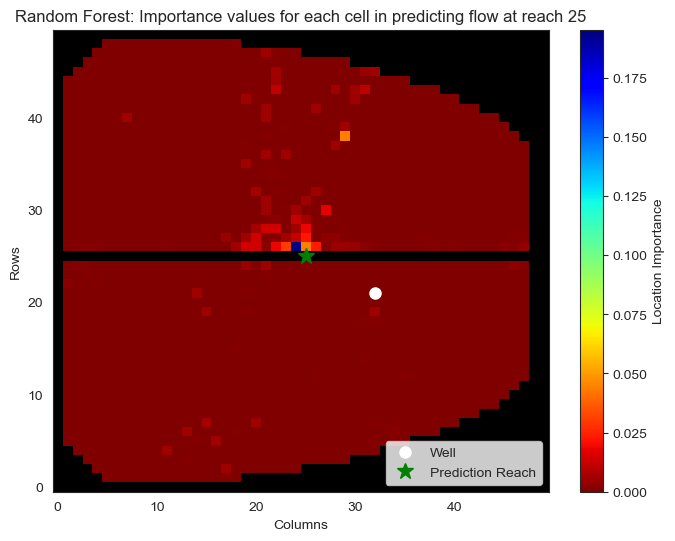

In [99]:
numTS = 1
rf_imp_df = pd.read_pickle('SteadyState_RF_Impdf.pkl')

rf_total_imp_df = rf_imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
print(rf_total_imp_df.sum())
#Sum up all the stress periods for each well location
rf_AllTSimp = rf_total_imp_df.groupby(rf_total_imp_df.index // numTS).sum()

#get indicies of every feature per TS (stressperiod)
TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

for i in range(numTS):
    featInTS = np.intersect1d(rf_total_imp_df.index, TSIndices+i)
    print(featInTS)
    print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
    print("Sum of Importances in Stress period " + str(i) + ": " + str(rf_total_imp_df.loc[featInTS].sum()))

    
max_well = rf_AllTSimp.idxmax()

print(int(well_loc_df.loc[max_well, 1]), int(well_loc_df.loc[max_well, 0]))
#feature importance Mapping
wellmesh_rf = np.ndarray((50,50))
wellmesh_rf[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

for k in rf_AllTSimp.index:
        wellmesh_rf[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = rf_AllTSimp.loc[k]


cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(rf_AllTSimp)
#vmax = 0.1
vmin = np.min(rf_AllTSimp)
plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_rf,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Random Forest: Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")


[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.96419839 0.98651288 0.95561707 1.        ]
 [0.95976932 0.98479047 0.95044983 1.        ]
 ...
 [0.03137255 0.2044752  0.44372165 1.        ]
 [0.03137255 0.19635525 0.43166474 1.        ]
 [0.03137255 0.18823529 0.41960784 1.        ]]


C:\Users\davem\AppData\Local\Temp\ipykernel_13108\967776756.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_bd = cm.get_cmap("gray")#,lut=20)


[Text(0.0, 0, ''),
 Text(0.15, 0, 'Random Forest'),
 Text(0.5, 0, 'Gradient Boosted'),
 Text(0.85, 0, 'Decision Tree'),
 Text(1.0, 0, '')]

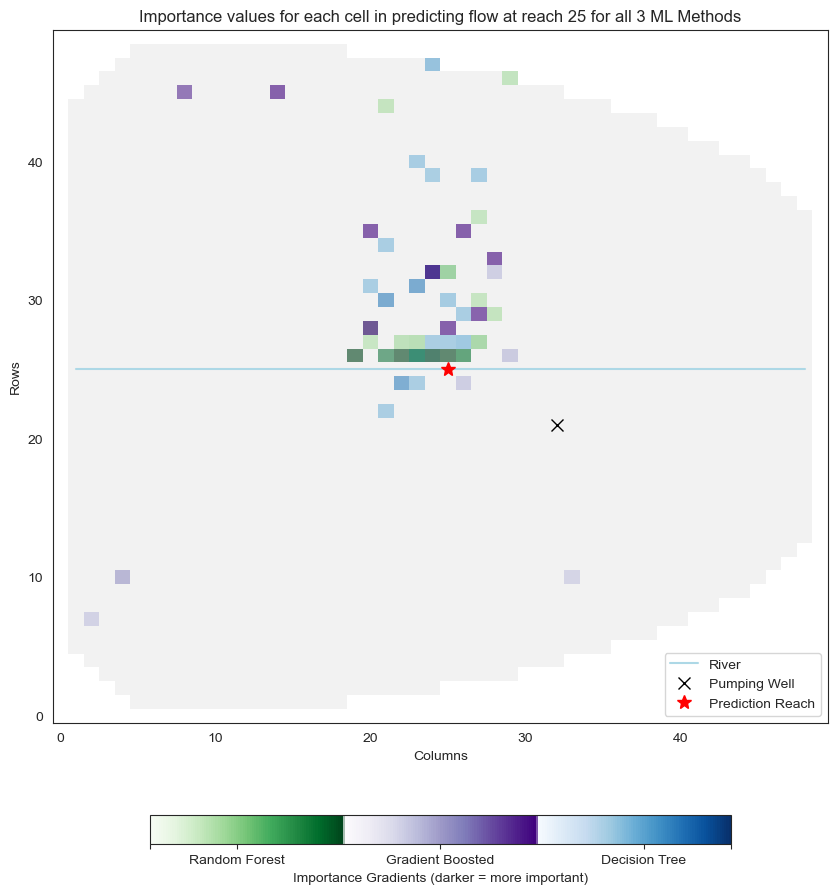

In [217]:
river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.01)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_gr, wellmesh_gr < 0.01)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_dt, wellmesh_dt < 0.01)

# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128))))
print(colors)

mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = vmax, vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmax, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmax, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmax, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Importance values for each cell in predicting flow at reach ' + str(rn) + ' for all 3 ML Methods')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.15,0.5,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Random Forest', 'Gradient Boosted','Decision Tree',''])
#plt.legend()

### Trying the Iterative random Forest 

https://github.com/Yu-Group/iterative-Random-Forest/blob/master/demo/03_iRF_demo_Regression.ipynb

In [21]:
print(all_well_loc)


[[ 1  5]
 [ 1  6]
 [ 1  7]
 ...
 [48 16]
 [48 17]
 [48 18]]


C:\Users\davem\AppData\Local\Temp\ipykernel_10884\1568857108.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_bd = cm.get_cmap("gray")#,lut=20)
C:\Users\davem\AppData\Local\Temp\ipykernel_10884\1568857108.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ch = cm.get_cmap("Paired")#,lut=20)


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

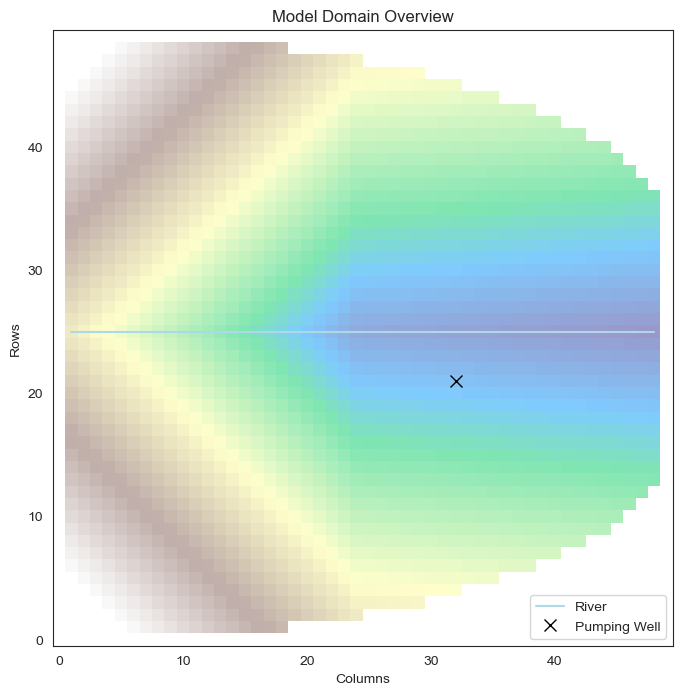

In [86]:
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)


wellmesh_ztop = np.ndarray((50,50))
wellmesh_ztop[:,:] = 0

for k in range(len(all_well_loc)):
    wellmesh_ztop[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = ztop[int(all_well_loc[k, 0]),int(all_well_loc[k, 1])]
wellmesh_ztop = np.ma.masked_array(wellmesh_ztop, wellmesh_ztop < 0.01)
river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")

cmap_ch = cm.get_cmap("Paired")#,lut=20)
cmap_ch.set_under("w")
#cmap_ch.set_over("k")

wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
wm_ch = wellmesh_bd.copy()

CHBound_loc = np.where(all_well_loc[:,1] == 48) 
rch_bound = np.where(all_well_loc[:,1] < 10) 
et_bound = np.where(all_well_loc[:,1] >= 10)
#print(CHBound_loc)

for k in range(len(all_well_loc)):
    wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

for j in rch_bound[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 3
for j in et_bound[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 4     
for j in CHBound_loc[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 2
wm_ch = np.ma.masked_array(wm_ch, wm_ch < 0.01)

    
fig, axs = plt.subplots(figsize=(8,8))
#plt.figure(figsize=(8,10))
alpha = 0.6
#axs.pcolormesh(KK,GG,wellmesh_bd, cmap = cmap_bd, shading='nearest', alpha = 0.05, ec='grey')
axs.pcolormesh(KK,GG,wellmesh_ztop, cmap = cm.terrain, shading='nearest', alpha = 0.5, ec='None')

#axs.pcolormesh(KK,GG,wm_ch, cmap = cmap_ch, shading='nearest', alpha = 0.5)

axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
#axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Model Domain Overview')
axs.legend(loc="lower right")
plt.colorbar()

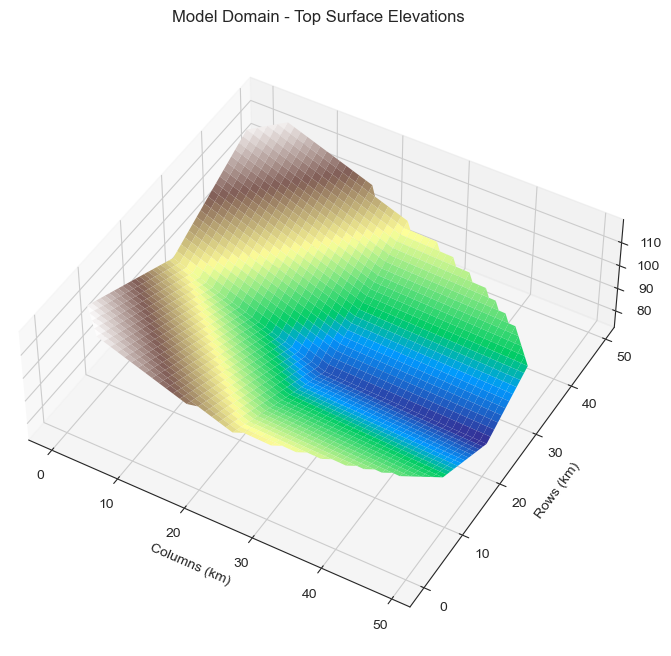

In [79]:

    
axes = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
axes.set_box_aspect([1,1,0.35])
axes.plot_surface(GG, KK, wellmesh_ztop, cmap = cm.terrain, edgecolor='None')
axes.set_title('Model Domain - Top Surface Elevations')
axes.set_xlabel('Columns (km)')
axes.set_ylabel('Rows (km)')
axes.set_zlabel('Elevation (m)')


axes.view_init(45, -50,0)
plt.savefig(r'C:\Users\davem\Documents\Thesis\Topsurface.png')